In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install facenet-pytorch --quiet

import os
import shutil
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from facenet_pytorch import InceptionResnetV1
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [14]:
import os

root = '/kaggle/input/attendance/Dataset'

for class_name in os.listdir(root):
    class_path = os.path.join(root, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {image_count} image(s)")


Khalid Image: 2 image(s)
Azaz Image: 7 image(s)
Samar Image: 4 image(s)


In [15]:
import os
import shutil
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from facenet_pytorch import InceptionResnetV1
from torch.optim import Adam
from tqdm import tqdm
from PIL import Image

In [24]:
original_path = '/kaggle/input/attendance/Dataset'
fixed_path = '/kaggle/working/attendance_fixed'
os.makedirs(fixed_path, exist_ok=True)

for folder in os.listdir(original_path):
    orig_path = os.path.join(original_path, folder)
    new_folder = folder.replace(" ", "_")
    new_path = os.path.join(fixed_path, new_folder)
    
    if os.path.isdir(orig_path):
        shutil.copytree(orig_path, new_path, dirs_exist_ok=True)


In [25]:
# === Step 2: Preprocessing + Augmentation (save to disk) ===
augmented_path = '/kaggle/working/augmented_attendance'
if os.path.exists(augmented_path):
    shutil.rmtree(augmented_path)
os.makedirs(augmented_path, exist_ok=True)

augmentation_transforms = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

In [26]:
def augment_and_save(original_dir, augmented_dir, num_augments=5):
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        if not os.path.isdir(class_dir): continue

        aug_class_dir = os.path.join(augmented_dir, class_name)
        os.makedirs(aug_class_dir, exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                continue

            base_name = os.path.splitext(img_file)[0]
            orig_resized = transforms.Resize((160, 160))(image)
            orig_resized.save(os.path.join(aug_class_dir, f"{base_name}_orig.jpg"))

            for i in range(num_augments):
                aug_img = augmentation_transforms(image)
                aug_img.save(os.path.join(aug_class_dir, f"{base_name}_aug{i}.jpg"))

augment_and_save(fixed_path, augmented_path, num_augments=5)


In [27]:
# === Step 3: Load dataset ===
load_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
dataset = datasets.ImageFolder(augmented_path, transform=load_transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# === Step 4: Print dataset size ===
print(f"✅ Total dataset size after augmentation: {len(dataset)} images")
print(f"✅ Classes: {dataset.classes}")


✅ Total dataset size after augmentation: 84 images
✅ Classes: ['Azaz_Image', 'Khalid_Image', 'Samar_Image']


In [28]:
# === Step 5: Fine-tuned FaceNet ===
num_classes = len(dataset.classes)
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=num_classes).to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final FC layer
for param in model.logits.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [29]:
# Training function
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        acc = 100 * correct / total
        print(f"📊 Epoch {epoch+1}: Loss={running_loss/len(dataloader):.4f}, Accuracy={acc:.2f}%")

# Train the model
train_model(model, loader, criterion, optimizer, epochs=10)

Epoch 1/10: 100%|██████████| 11/11 [00:01<00:00,  9.82it/s]


📊 Epoch 1: Loss=0.9561, Accuracy=54.76%


Epoch 2/10: 100%|██████████| 11/11 [00:00<00:00, 34.14it/s]


📊 Epoch 2: Loss=0.6105, Accuracy=71.43%


Epoch 3/10: 100%|██████████| 11/11 [00:00<00:00, 33.31it/s]


📊 Epoch 3: Loss=0.5488, Accuracy=83.33%


Epoch 4/10: 100%|██████████| 11/11 [00:00<00:00, 35.31it/s]


📊 Epoch 4: Loss=0.4162, Accuracy=91.67%


Epoch 5/10: 100%|██████████| 11/11 [00:00<00:00, 34.79it/s]


📊 Epoch 5: Loss=0.3501, Accuracy=90.48%


Epoch 6/10: 100%|██████████| 11/11 [00:00<00:00, 35.67it/s]


📊 Epoch 6: Loss=0.4633, Accuracy=85.71%


Epoch 7/10: 100%|██████████| 11/11 [00:00<00:00, 34.98it/s]


📊 Epoch 7: Loss=0.2513, Accuracy=91.67%


Epoch 8/10: 100%|██████████| 11/11 [00:00<00:00, 33.21it/s]


📊 Epoch 8: Loss=0.2855, Accuracy=90.48%


Epoch 9/10: 100%|██████████| 11/11 [00:00<00:00, 35.70it/s]


📊 Epoch 9: Loss=0.2379, Accuracy=95.24%


Epoch 10/10: 100%|██████████| 11/11 [00:00<00:00, 33.29it/s]

📊 Epoch 10: Loss=0.1898, Accuracy=96.43%


In [30]:
# Save model
torch.save(model.state_dict(), '/kaggle/working/facenet_finetuned_augmented.pth')
print("✅ Model saved to /kaggle/working/facenet_finetuned_augmented.pth")

✅ Model saved to /kaggle/working/facenet_finetuned_augmented.pth


In [42]:
# === Step 6: Testing on same set (optional) ===
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"🧪 Final Testing Accuracy on Augmented Set: {100 * correct / total:.2f}%")

🧪 Final Testing Accuracy on Augmented Set: 92.86%


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

# Collect predictions and labels
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_probs = np.array(all_probs)

# === Classification Report ===
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


📝 Classification Report:
              precision    recall  f1-score   support

  Azaz_Image       1.00      0.88      0.93        48
Khalid_Image       0.71      1.00      0.83        12
 Samar_Image       0.96      1.00      0.98        24

    accuracy                           0.93        84
   macro avg       0.89      0.96      0.91        84
weighted avg       0.95      0.93      0.93        84




🧩 Confusion Matrix:


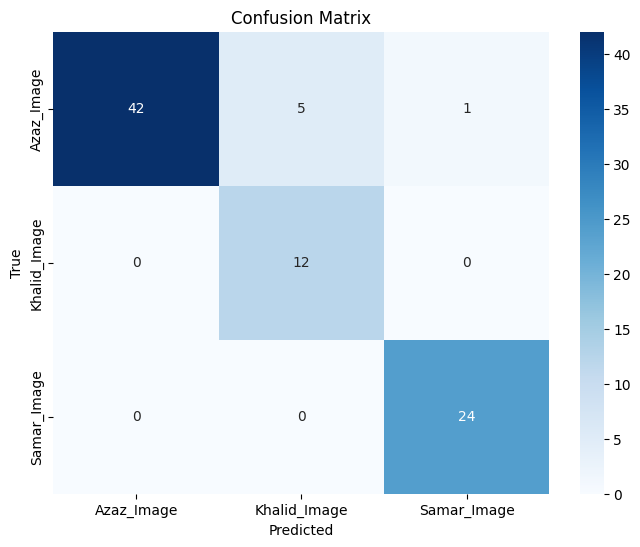

In [33]:
# === Confusion Matrix ===
print("\n🧩 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


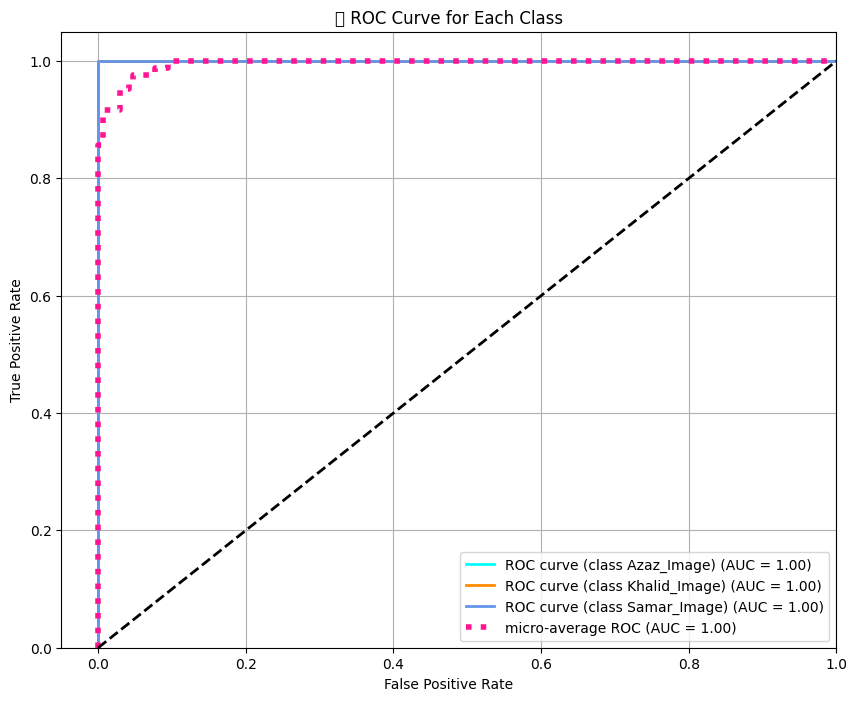

In [35]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# One-hot encode the labels
y_onehot = label_binarize(y_true, classes=range(len(dataset.classes)))
n_classes = y_onehot.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve (class {dataset.classes[i]}) (AUC = {roc_auc[i]:0.2f})")

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f"micro-average ROC (AUC = {roc_auc['micro']:0.2f})",
         color='deeppink', linestyle=':', linewidth=4)

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [36]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 34.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 107.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.8 MB/s eta 0:00:00


In [41]:
!pip install gradio facenet-pytorch --quiet

import gradio as gr
import torch
import torch.nn.functional as F
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load Classes (from training folder)
classes = sorted(os.listdir('/kaggle/working/augmented_attendance'))

# === Load Model ===
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=len(classes))
model.load_state_dict(torch.load('/kaggle/working/facenet_finetuned_augmented.pth', map_location=device))
model.eval().to(device)

# === Preprocessing (must match training) ===
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Prediction Function ===
def predict(image):
    image = Image.fromarray(image).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)[0]
        confidence, pred_class = torch.max(probs, 0)
    
    return {classes[i]: float(probs[i]) for i in range(len(classes))}

# === Gradio Interface ===
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="Upload Face Image"),
    outputs=gr.Label(num_top_classes=3),
    title="🧠 Face Recognition with Fine-Tuned FaceNet",
    description="Upload a face image to identify the person (Khalid, Azaz, etc.) using the fine-tuned FaceNet model."
)

# Launch (For Kaggle, use .launch(share=True) if running in notebook)
iface.launch()


* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://8b449879a93af3efc5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
